# Semi-Automatic postprocessing of mouse eye blink data

**Targets** in descending priority order
1. Frames with full blink _[Mostly solved]_
2. Frames with partial blink. In general, magnitude of blink _[Unsolved]_
3. Pupil size _[Partially solved]_

**Method**: Extract quantity of bright pixels in the eye as function of time. Estimate information from this data

**Challenges of setup**:
1. Pupil changes size, centroid and brightness. 
2. Background is very bright. During eye closure background can intersect with pupil position
3. [Solved] In presence of whiskers there is extra reflected light. Although, it seems whiskers are only there when eye is open. Also, it is possible to trim whiskers
4. [Solved] Closing eye with paw reflects a lot of light. Typically this increases the average brightness dramatically

**Solution Method**:
1. Merge videos using video merging script
2. ImageJ:
  * Import merged video
  * Crop video to a circle as large as possible while fully contained inside the eye during video. Clear outside
  * Change minimal brightness/contrast such that pupil is always visible, but the hair is not.
  * Extract average brightness and fraction of non-zero pixels.
  * Move the resulting file to the analysis directory and rename it accordingly.
3. This file
  * Import data
  * Mark all data with too high average brightness as "Blink caused by paw"
  * Apply high-pass filter to remove slow effects of pupil partially drifting out of FOV
  * Mark all data with too low non-zero pixel count as "Blink", the rest as "Not Blink"
  
**Challenges of the method**:
1. Motion causes pupil to partially drift out of field of view. In most cases the process is slow and can be dealt with via low-pass filter. However, cases with rapid change also exist, which result in false blink. 
2. Filtering: optimal frequency for low-pass filter unclear. Too high frequency results in skip of longer blinks. Too low frequency falsely considers partial drift of pupil out of FOV as a blink, whereas regular blinks have much faster change of brightness.
3. Thresholding: optimal threshold for number of bright pixels between blink and not blink unclear. Need to identify why for some blinks number of nonzero pixels is significantly higher than for others.
4. There is no easy way to consistently determine by how much the eye is closed/open. In order to distinguish change of pupil size from it being covered by eyelid, the shape of the pupil has to be considered. However, pupil size should be possible to predict more or less consistently, as most of the time the eye is fully open.

**Future work**:
1. Pupil: It will be possible to determine the pupil size, if the motion correction problem is solved. After subtracting frames when eye is closed, the non-zero pixel count should correlate with pupil diameter. Additional frequency filtering may be necessary.
2. Accuracy of blink prediction: It should be possible to use speed of change of non-zero pixels as additional validation of the blink.
3. Length of blink: Currently, the start time of blinks is too late, as the closing motion starts before a large amount of pixels get covered. Similarly, the finish time of the blinks is too late, since the opening motion starts before the pixels are revealed again. Expand each blink region into the past, until maximum is reached, and decrease it from the future, until minimum is reached. Difference of minimum and maximum, divided by the length of the blink can be used as effective speed in blink validation.

**Useful Links**
1. FFT
  * https://dsp.stackexchange.com/questions/724/low-pass-filter-and-fft-for-beginners-with-python/725
2. Installing on Win
  * http://adaptivesamples.com/how-to-install-ffmpeg-on-windows/

In [1]:
import csv
import numpy as np

with open('results/rez_VGlut_4_100418_analysis1.txt', 'r') as f:
  csvReader = csv.reader(f, delimiter=' ')
  intensityData = np.array([[float(elem) for elem in line] for line in csvReader])
  
print(intensityData)

[[  0.00000000e+00   5.27252759e-01   4.46341463e-01   4.41293153e-01]
 [  1.00000000e+00   5.18429244e-01   4.49390244e-01   4.41170089e-01]
 [  2.00000000e+00   5.18815526e-01   4.48170732e-01   4.40693540e-01]
 ..., 
 [  9.02263000e+05   5.75933277e-01   2.98170732e-01   5.01890846e-01]
 [  9.02264000e+05   5.71265889e-01   2.98170732e-01   5.02044311e-01]
 [  9.02265000e+05   5.79087668e-01   2.95121951e-01   5.02413879e-01]]


<IPython.core.display.Javascript object>


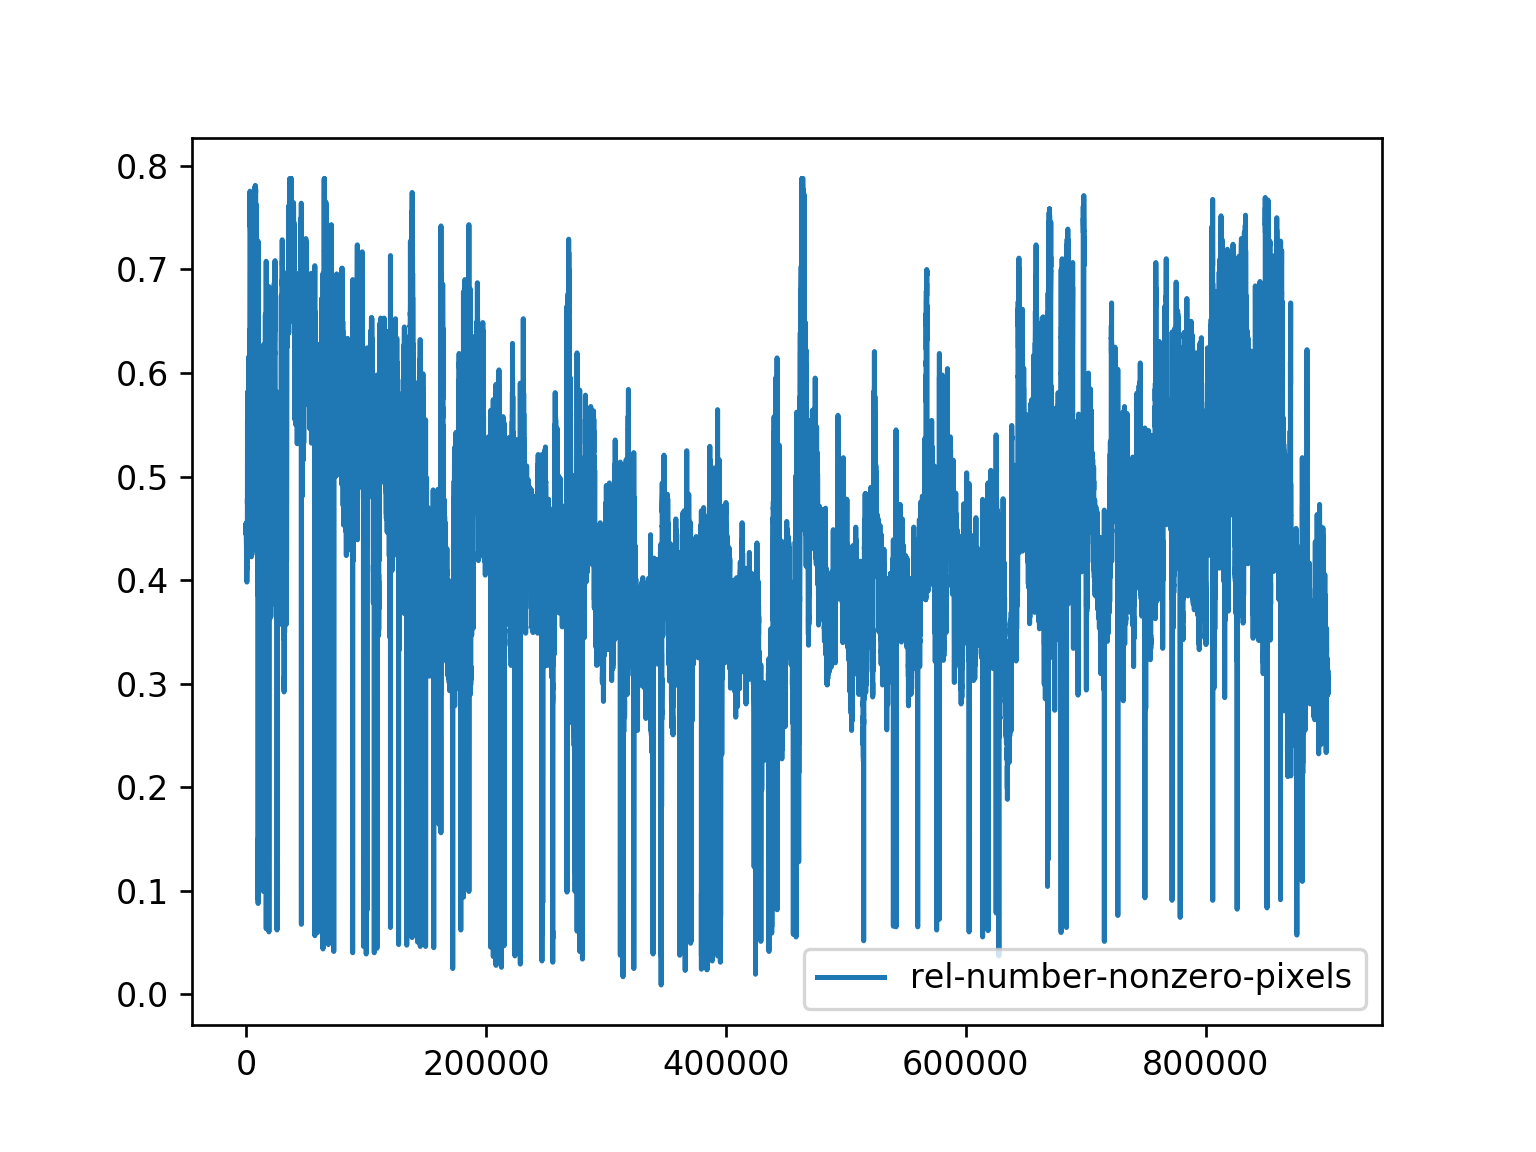

In [3]:
import matplotlib.pyplot as plt
%matplotlib notebook

intensityAvg = np.average(intensityData[:, 1])

fig = plt.figure()
#plt.plot(intensityData[:, 0], intensityData[:, 1], label='average-brightness')
#plt.plot(intensityData[:, 0], [intensityAvg]*len(intensityData[:, 1]), label='total-brightness')
plt.plot(intensityData[:, 0], intensityData[:, 2], label='rel-number-nonzero-pixels')
#plt.plot(intensityData[:, 0], intensityData[:, 3], label='radial-brightness')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


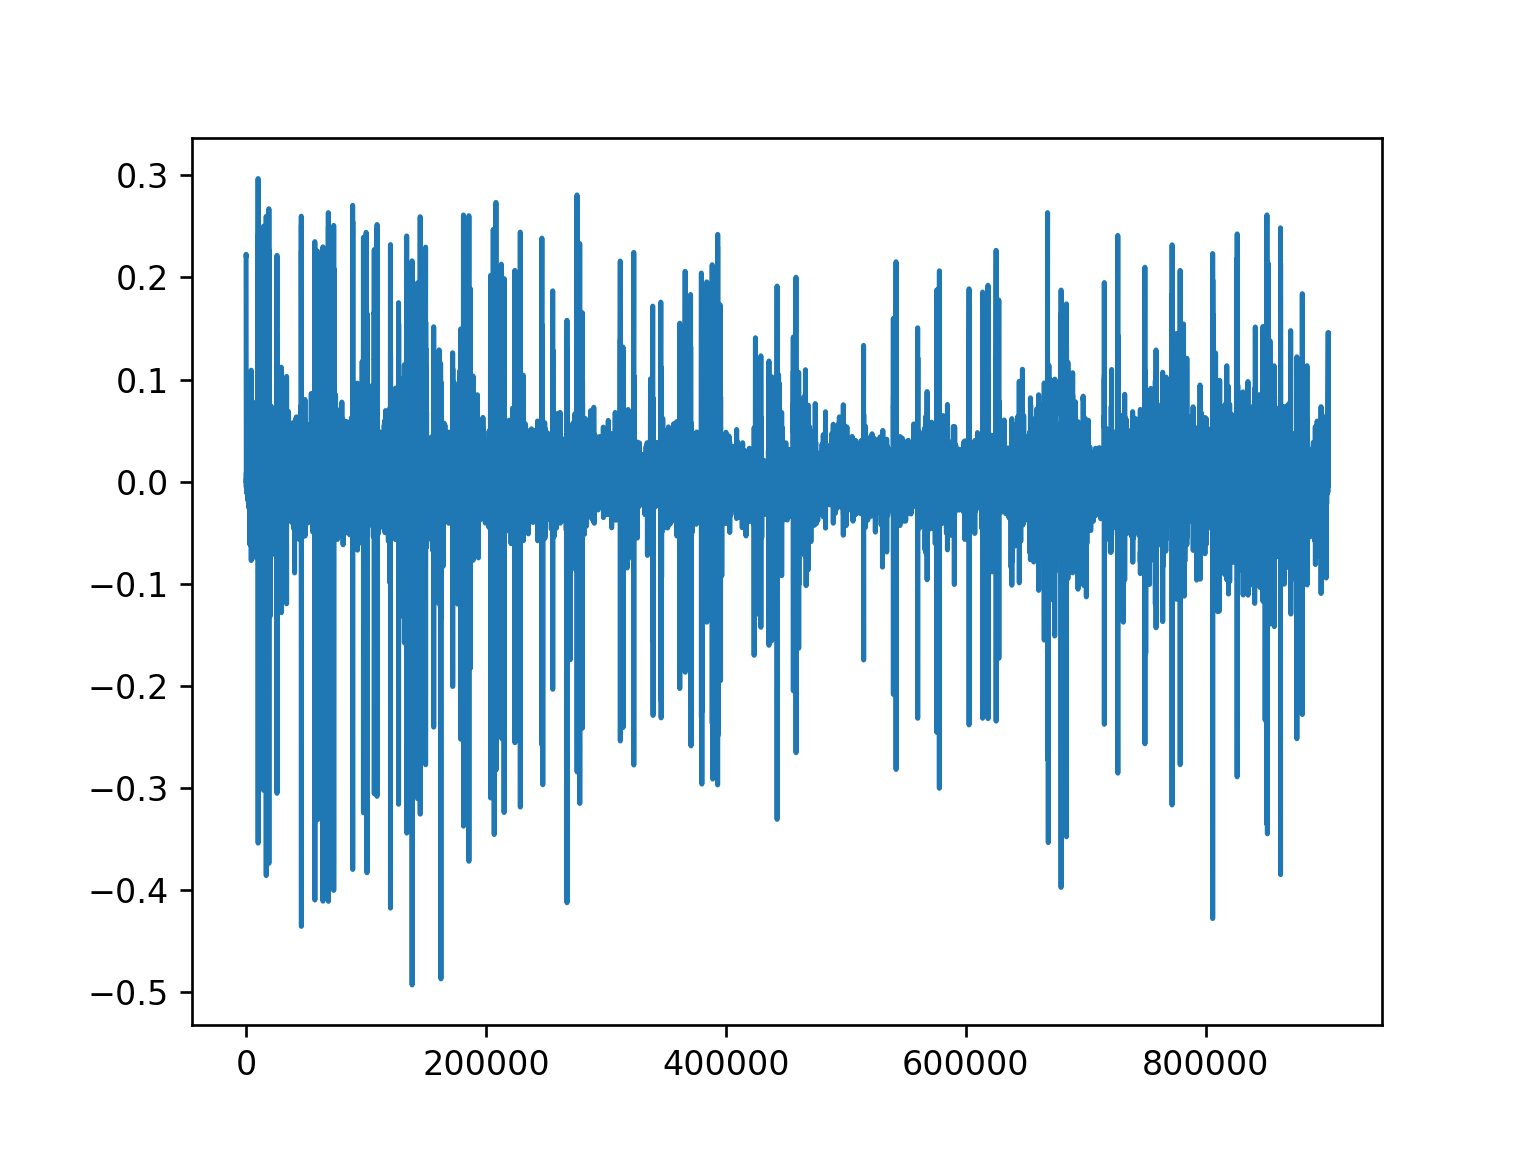

In [41]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

smoothdata = smooth(intensityData[:, 2], 200)


fig = plt.figure()
plt.plot(intensityData[:, 0], intensityData[:, 2] - smoothdata, label='rel-pix-norm')
plt.show()

<IPython.core.display.Javascript object>


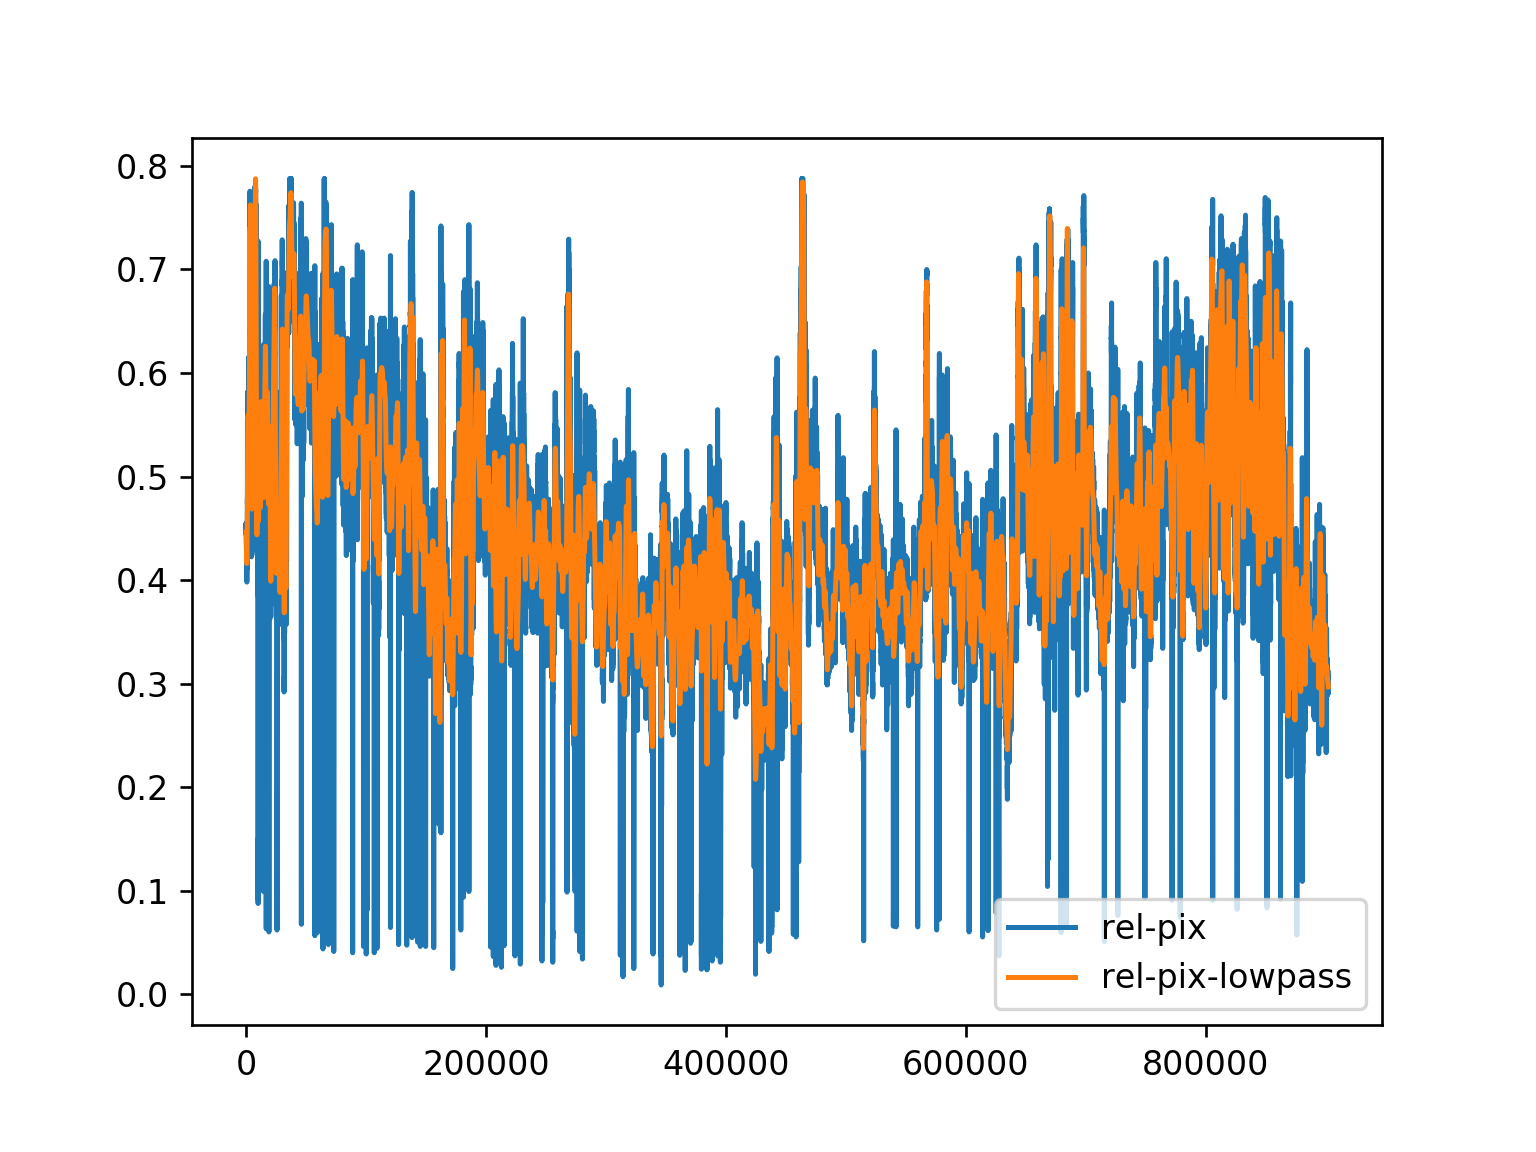

In [67]:
from scipy import signal

def butter_highpass(cutoff, fps, order=5):
    nyq = 0.5 * fps
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fps, order=5):
    b, a = butter_highpass(cutoff, fps, order=order)
    y = signal.filtfilt(b, a, data)
    return y


intensityDataHP = butter_highpass_filter(intensityData[:, 2], 0.2, 250)
intensityDataLP = intensityData[:, 2]-intensityDataHP

fig = plt.figure()
plt.plot(intensityData[:, 0], intensityData[:, 2], label='rel-pix')
plt.plot(intensityData[:, 0], intensityDataLP, label='rel-pix-lowpass')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


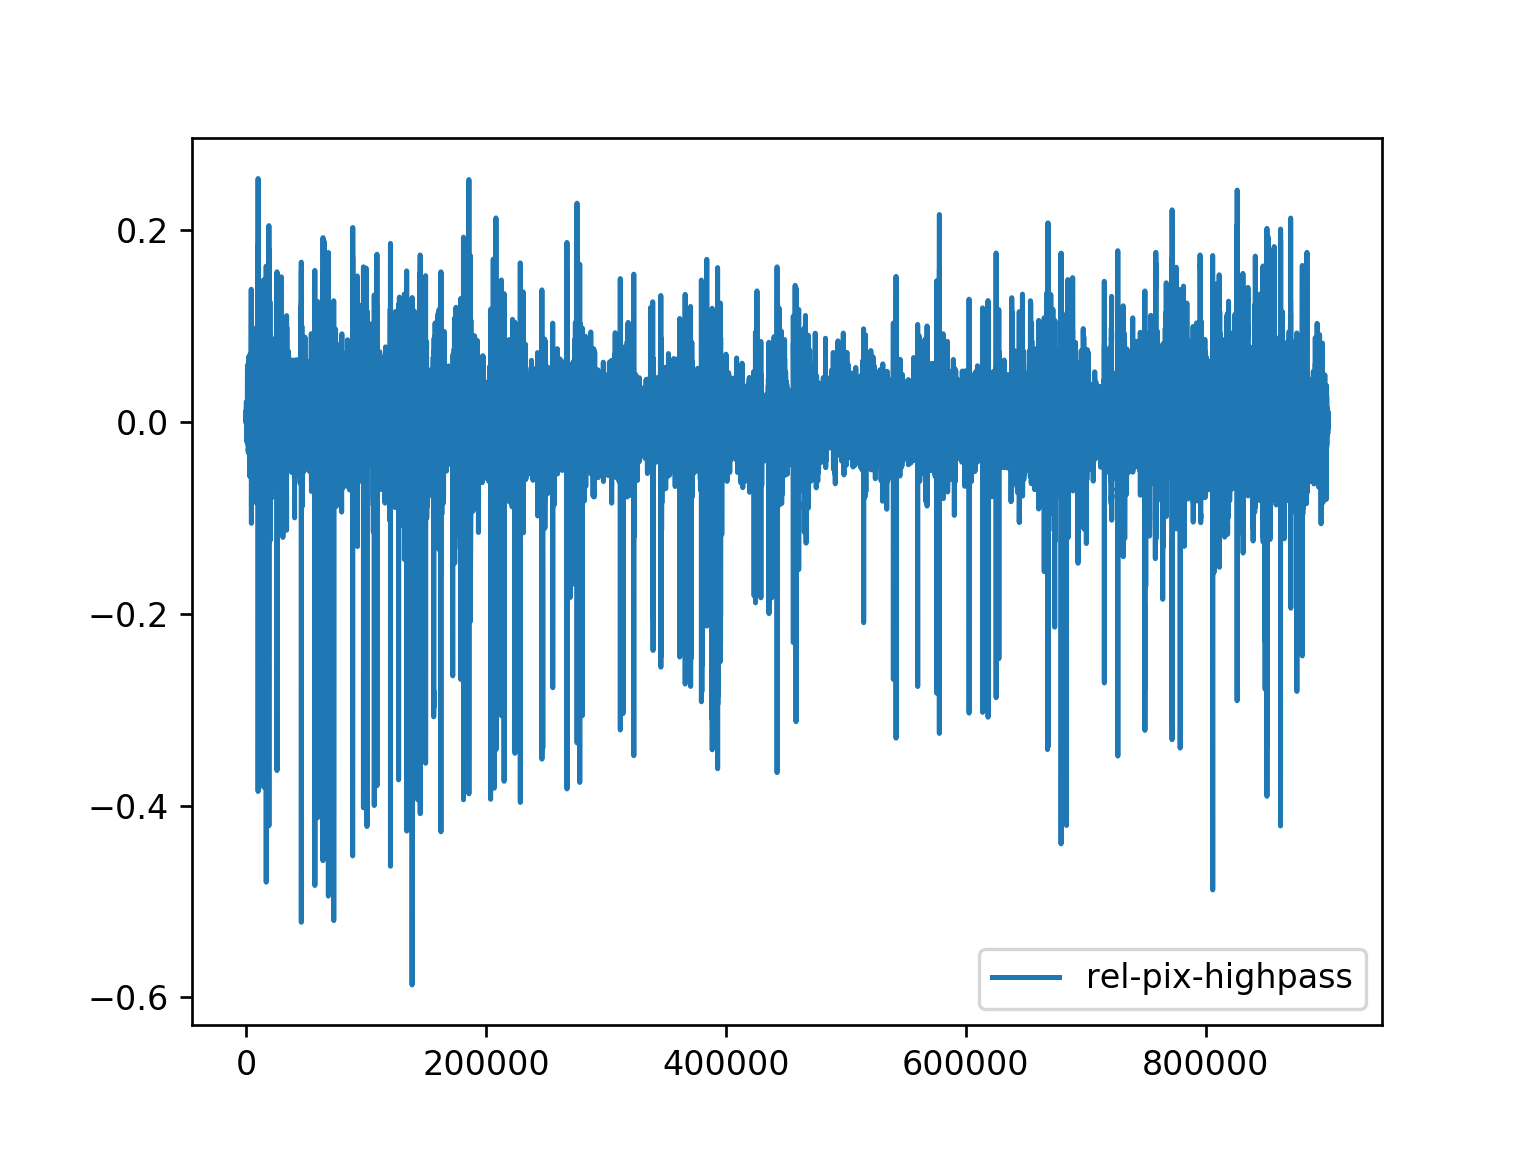

In [5]:
fig = plt.figure()
plt.plot(intensityData[:, 0], intensityDataHP, label='rel-pix-highpass')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


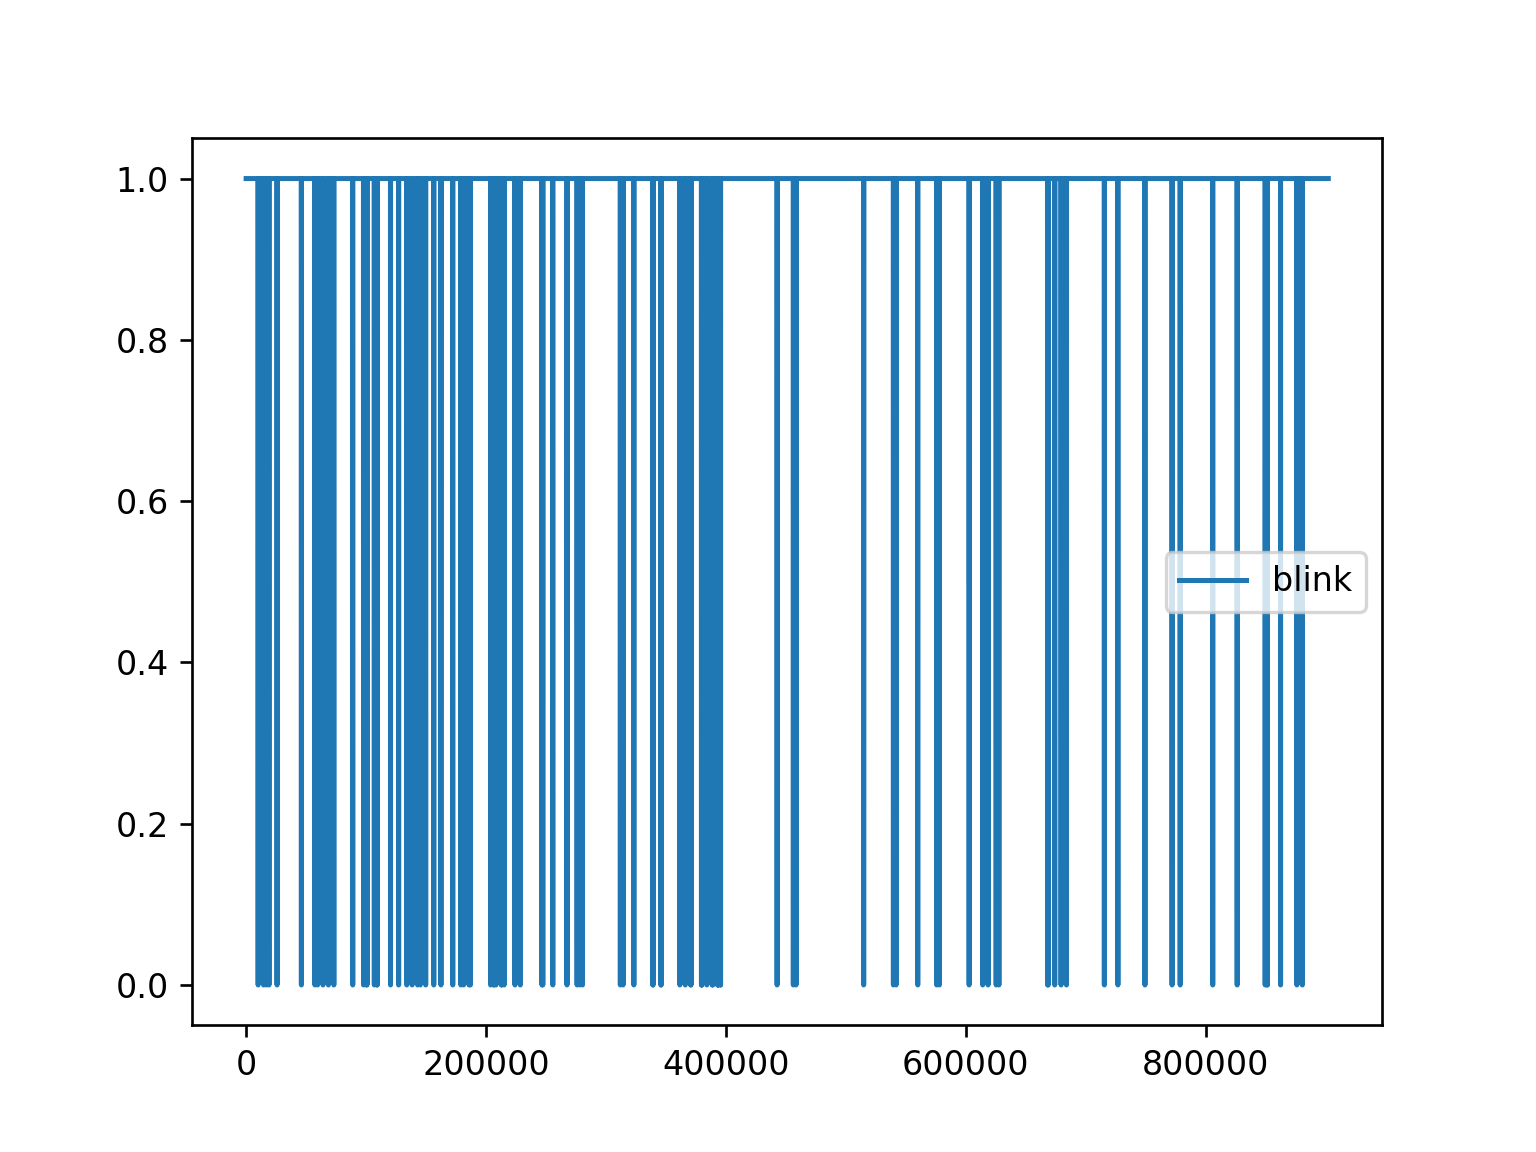

In [6]:
blinkCutoff = 0.8
framesBlink = np.copy(intensityDataHP) + 1

framesBlink[framesBlink < blinkCutoff] = 0
framesBlink[framesBlink >= blinkCutoff] = 1

fig = plt.figure()
plt.plot(intensityData[:, 0], framesBlink, label='blink')
plt.legend()
plt.show()

# Postprocessing

**Targets**:
1. Determine specifics of blinking pattern under specific conditions (training/expert, no chemistry vs chemistry, etc.)

**Solution**
1. Read trial length file, assign blinks to corresponding trials
2. Read conditions file, separate all trials by condition
3. Plot average blink probability for each condition
  * Align! Different trials have different length.
  * Normalize!
     
**Challenges to Analysis:**
1. There are several tests on blinking pattern that can be performed. It must be decided which test is meaningful
  * [Done] Matrix of all blink times
  * [DONE] Probability of being in a blink state. Would correlate with signals that preserve blinking, but not with signals that initiate blinking
  * [????] Probability of start of a blink. May be inconsistent, as there is no clear distinction between one long blink and several short blinks, but they will contribute differently to the average
  * [Done] Total time spent blinking
  * [Done] Distribution of number of blinks per trial.
  * [Done] Distribution of start time of first blink.
  * [????] Blink pattern clustering
  
**Conclusions**
1. Most blinks are jittery - algorithm estimates 1-3 blinks within short distance of each other. The effect is a mixture of actual opening the eye before closing it again, and unexpected increase in brightness due to the fur reflection, unrelated to eye opening. Thus, the estimated blink count can be used as a behavioural estimator (of e.g. level of annoyance), however, it likely overestimates the effect.
2. [TODO] Most blinks appear to be synchronized with the stimulus, however, some are not. It is of high interest to check if the non-synchronized blinks are true blinks false positives.
3. There is only one blink at the start of the video. Blinks at the start of the video are likely to be fake, caused by omission of certain number of frames inbetween trials. If this effect ever becomes significant, background separation on an individual trial-to-trial basis could be employed.

In [65]:
##############################################
# Load trial lengths
##############################################
with open('results/framecounts/framecount_VGlut_4_100418.txt', 'r') as f:
  reader = csv.reader(f, delimiter=' ')
  lines = np.array([line for line in reader])
  names = lines[:,1]
  lengths = np.array([int(frcount) for frcount in lines[:,0]])
    
##############################################
# Distribute blinks to trials
##############################################
print("distributing", sum(lengths),"=",len(framesBlink), "frames over", len(lengths), "trials")
print("Shifts of merged video w.r.t individual trials:")
print("TrialN0 | Shift")

shifts = [0]
for i in range(len(lengths)):
    shifts.append(shifts[i]+lengths[i])
    print(i, shifts[i])
    
framesBlinkTrials = [framesBlink[shifts[i]:shifts[i+1]] for i in range(len(shifts)-1)]


##############################################
# Align trials to same starting point
##############################################
maxTrialLength = max([len(fr) for fr in framesBlinkTrials])
minTrialLength = min([len(fr) for fr in framesBlinkTrials])
#print(maxTrialLength)
#print(minTrialLength)
framesBlinkTrialsAligned = np.array([fr[:minTrialLength] for fr in framesBlinkTrials])
framesOpenTrialsAligned = 1.0-framesBlinkTrialsAligned

#print(framesBlinkTrialsAligned.shape)

##############################################
# Determine blink period starting points and lengths
##############################################

def countPartitions(lst, delimiter):
    blinkCount = 0
    timesThis = []
    lengthsThis = []
    for i in range(len(lst)):
        if lst[i] != delimiter:
            if blinkCount == 0:
                timesThis.append(i)
            blinkCount += 1
        else:
            if blinkCount != 0:
                lengthsThis.append(blinkCount)
            blinkCount = 0
    if blinkCount != 0:
        lengthsThis.append(blinkCount)
        
    return timesThis, lengthsThis

# Convert to length and start time
blinkPartitions = [countPartitions(tr, 0) for tr in framesOpenTrialsAligned]
framesBlinkTrialsStartTimes = [bpart[0] for bpart in blinkPartitions]
framesBlinkTrialsLengths = [bpart[1] for bpart in blinkPartitions]

distributing 902266 = 902266 frames over 400 trials
Shifts of merged video w.r.t individual trials:
TrialN0 | Shift
0 0
1 2222
2 4472
3 6722
4 8974
5 11226
6 13478
7 15730
8 17982
9 20234
10 22486
11 24739
12 26991
13 29242
14 31495
15 33747
16 35998
17 38250
18 40502
19 42755
20 45009
21 47260
22 49513
23 51766
24 54017
25 56270
26 58522
27 60774
28 63028
29 65280
30 67532
31 69784
32 72038
33 74289
34 76542
35 78794
36 81047
37 83300
38 85552
39 87805
40 90057
41 92309
42 94561
43 96813
44 99066
45 101319
46 103572
47 105826
48 108078
49 110330
50 112581
51 114834
52 117087
53 119339
54 121591
55 123844
56 126098
57 128352
58 130606
59 132859
60 135111
61 137364
62 139617
63 141870
64 144123
65 146377
66 148632
67 150885
68 153138
69 155392
70 157647
71 159903
72 162160
73 164416
74 166671
75 168927
76 171183
77 173441
78 175697
79 177951
80 180201
81 182463
82 184726
83 186989
84 189267
85 191520
86 193773
87 196026
88 198278
89 200531
90 202784
91 205037
92 207290
93 209542
94 2117

<IPython.core.display.Javascript object>


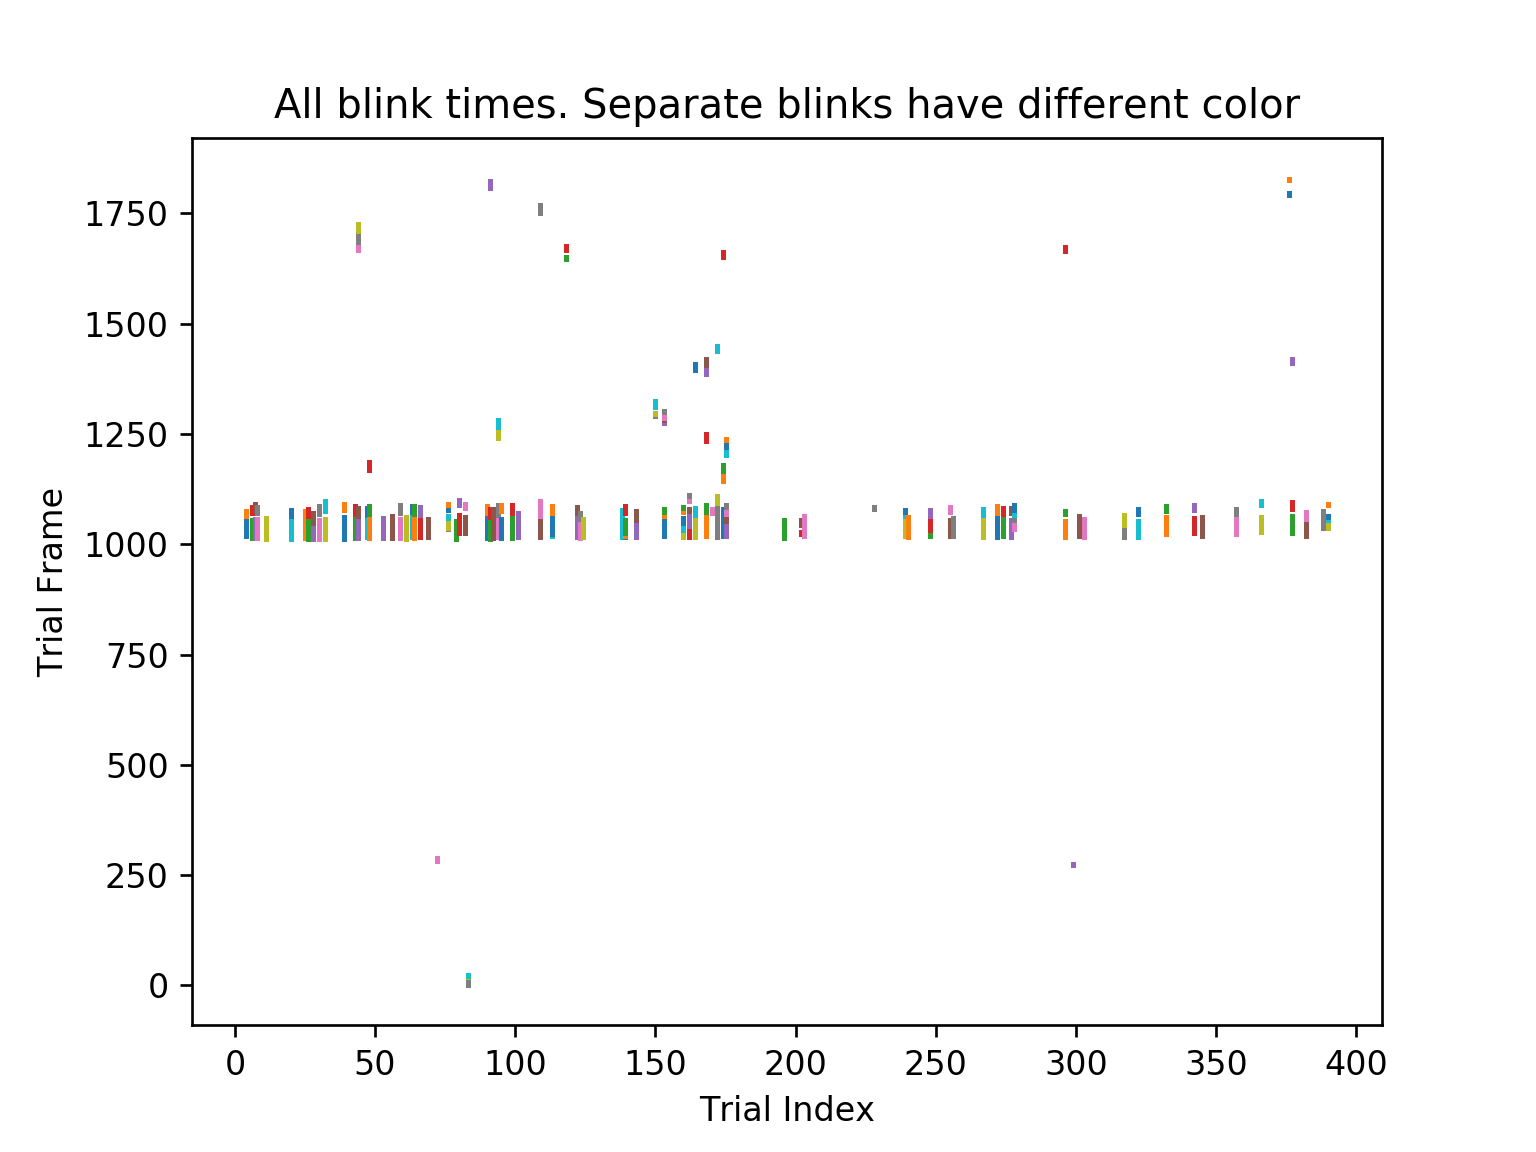

In [66]:
##############################################
# All blink times and lengths
##############################################

fig = plt.figure()

for i in range(len(blinkPartitions)):
    for st, l in zip(blinkPartitions[i][0], blinkPartitions[i][1]):
        plt.plot([i, i], [st, st+l])

plt.title("All blink times. Separate blinks have different color")
plt.xlabel("Trial Index")
plt.ylabel("Trial Frame")
plt.show()

<IPython.core.display.Javascript object>


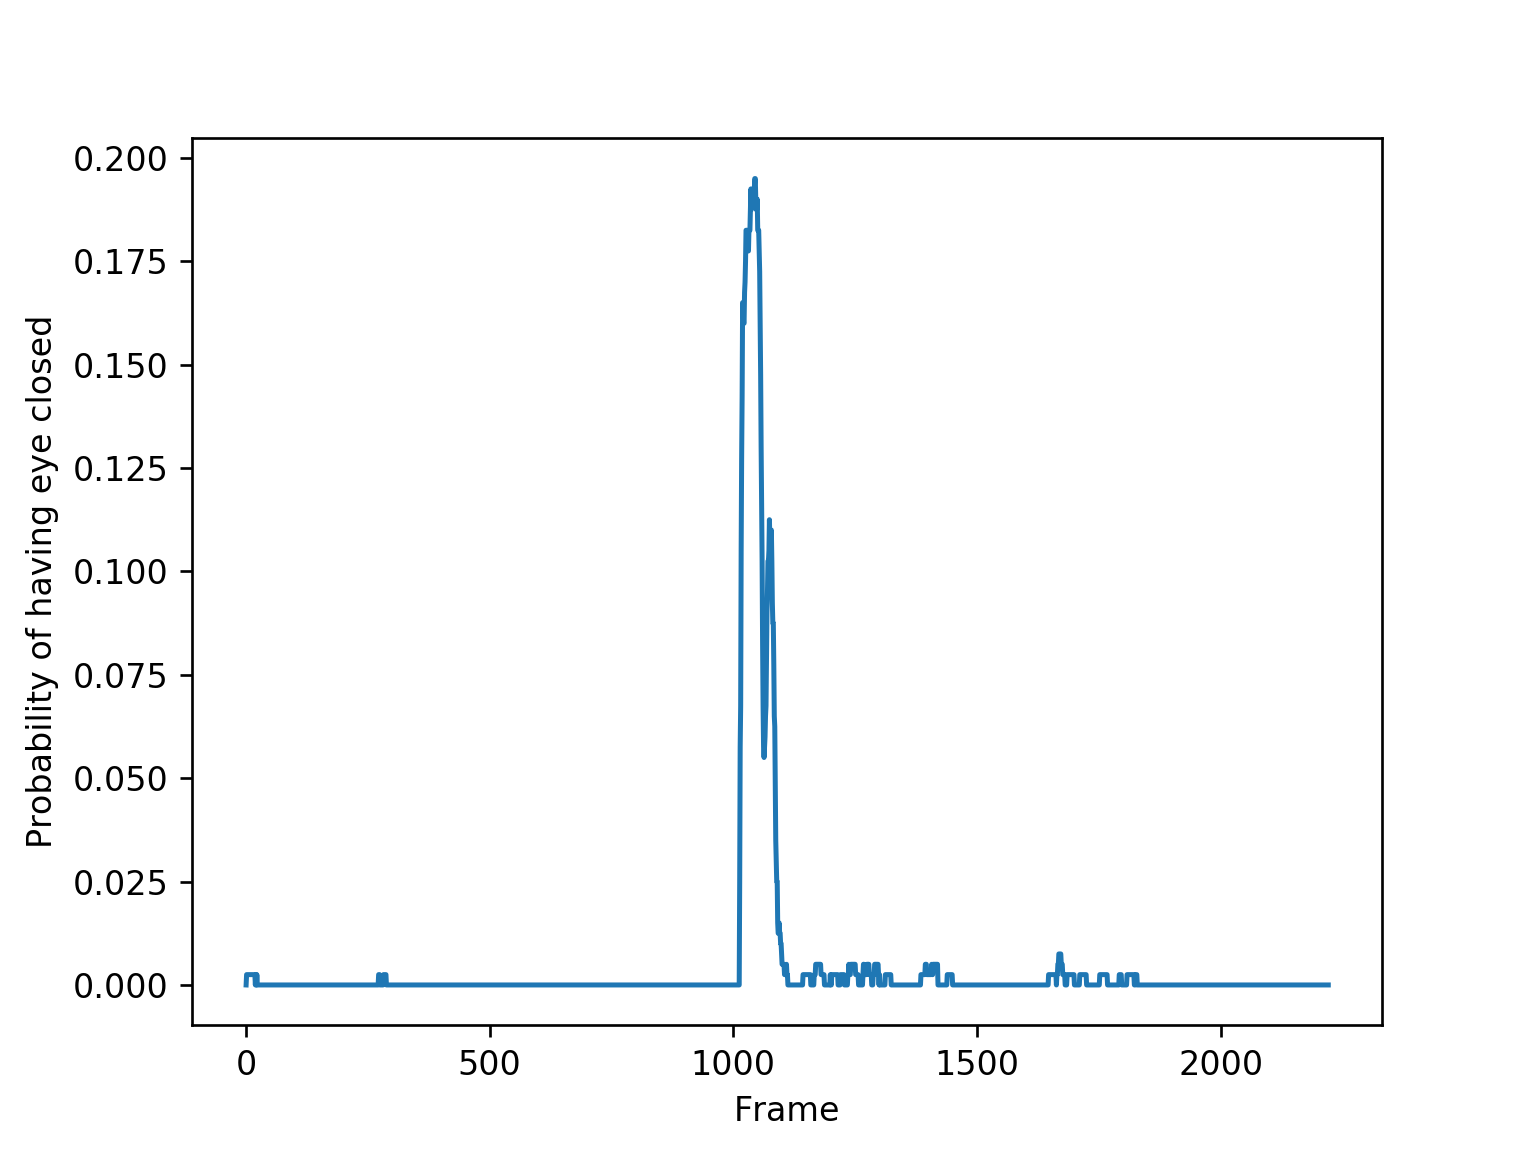

In [47]:
##############################################
# Blink state probability distribution
##############################################
framesOpenTrialsAvg = np.average(framesOpenTrialsAligned, axis=0)

fig = plt.figure()
plt.plot(framesOpenTrialsAvg)
plt.xlabel("Frame")
plt.ylabel("Probability of having eye closed")
plt.show()

<IPython.core.display.Javascript object>


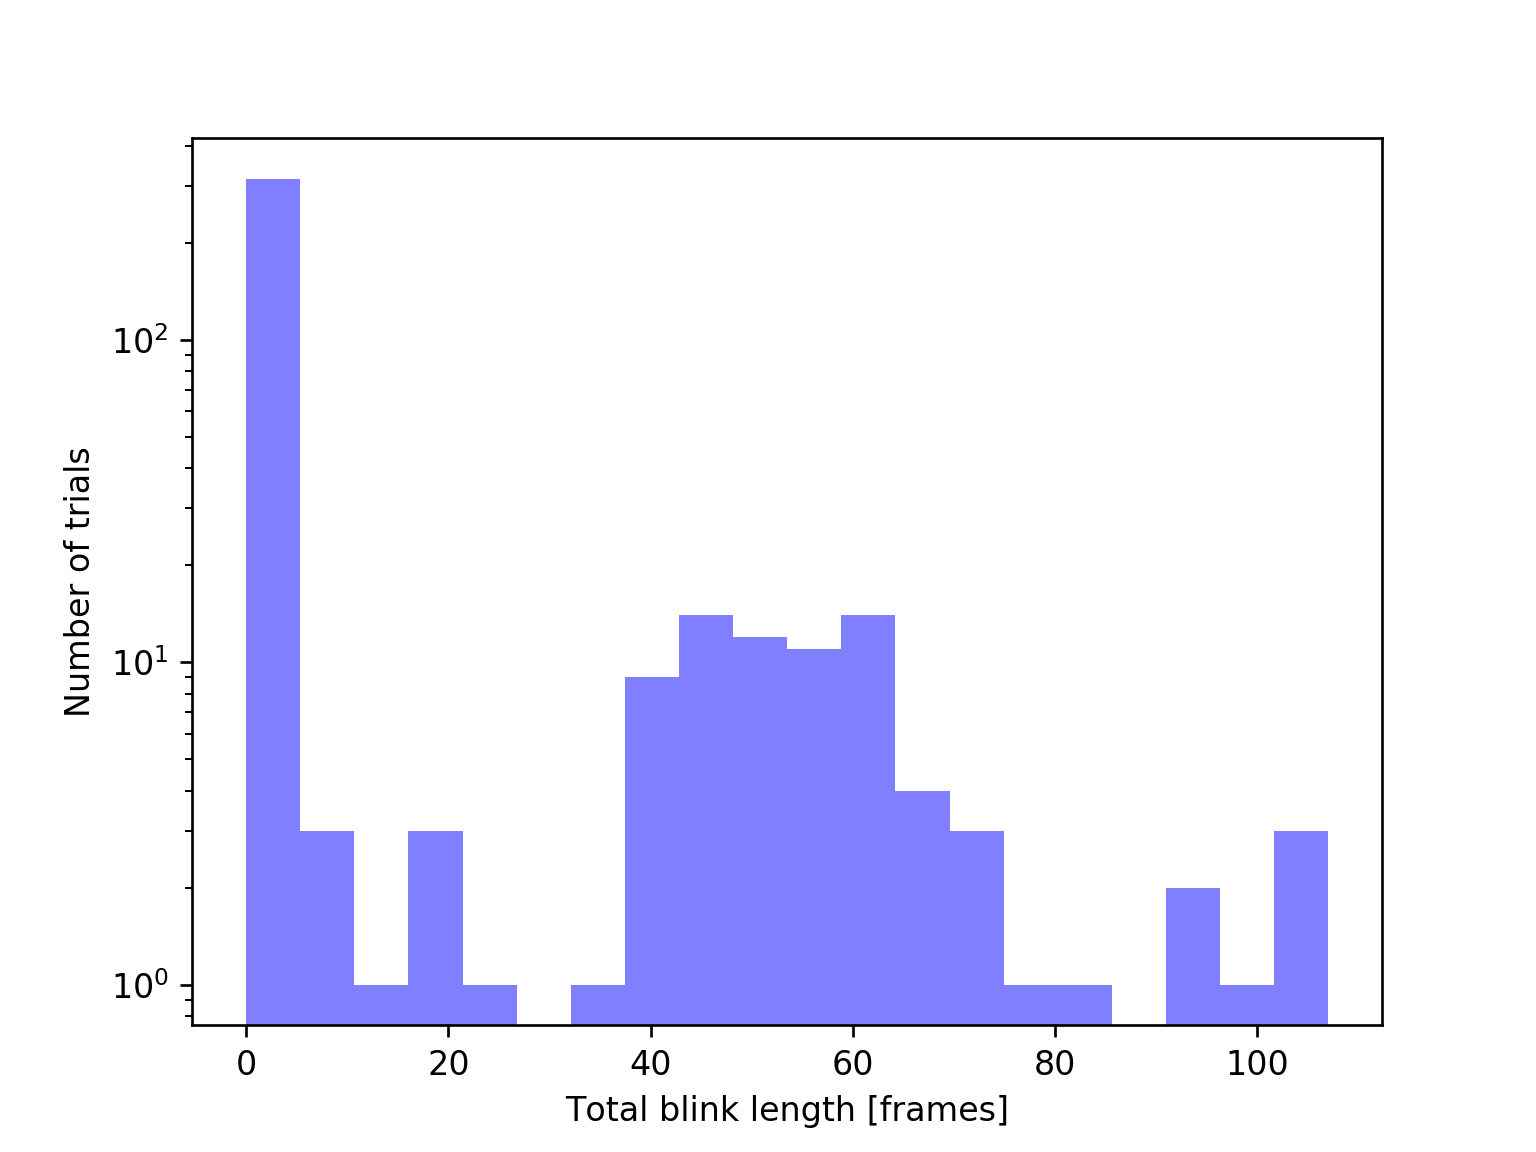

In [48]:
##############################################
# Total blink time histogram
##############################################

totalBlinkTimeTrials = np.sum(framesOpenTrialsAligned, axis=1)

fig = plt.figure()
num_bins = 20
n, bins, patches = plt.hist(totalBlinkTimeTrials, num_bins, facecolor='blue', alpha=0.5)
plt.yscale('log', nonposy='clip')
plt.xlabel("Total blink length [frames]")
plt.ylabel("Number of trials")
plt.show()

<IPython.core.display.Javascript object>


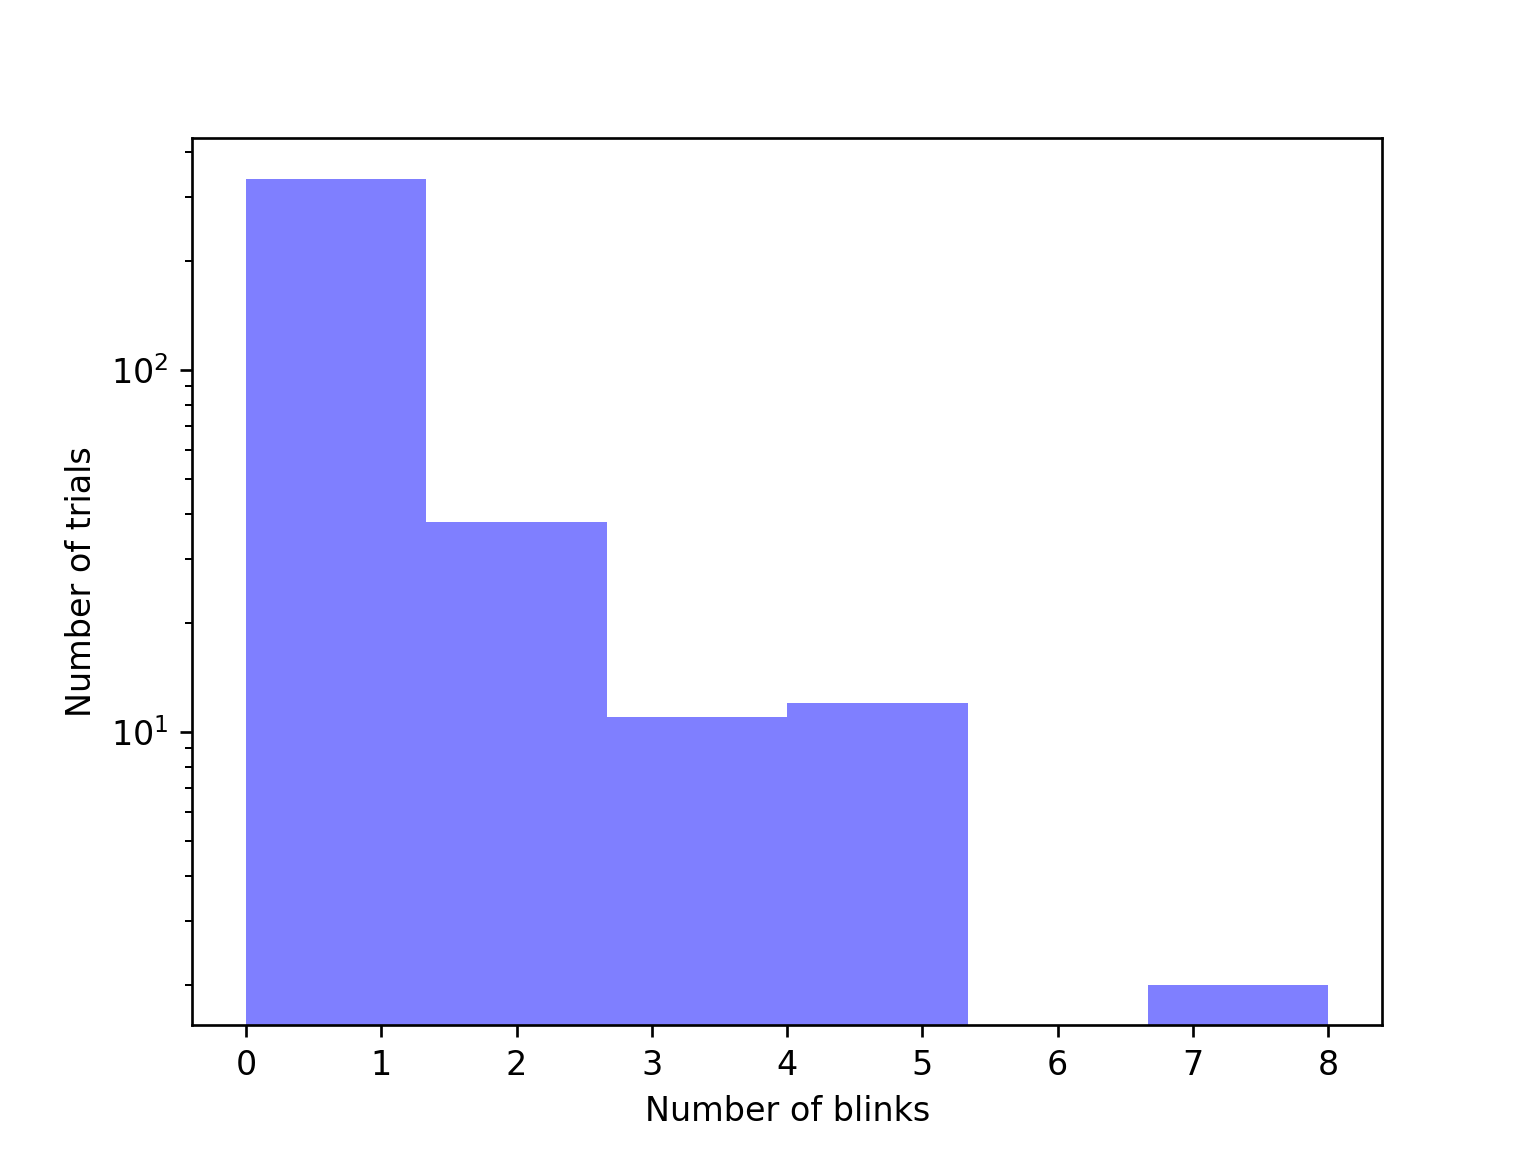

In [49]:
##############################################
# Blink count histogram
##############################################

countBlinksTrials = [len(l) for l in framesBlinkTrialsLengths]

fig = plt.figure()
num_bins = 6 
n, bins, patches = plt.hist(countBlinksTrials, num_bins, facecolor='blue', alpha=0.5)
plt.yscale('log', nonposy='clip')
plt.xlabel("Number of blinks")
plt.ylabel("Number of trials")
plt.show()

<IPython.core.display.Javascript object>


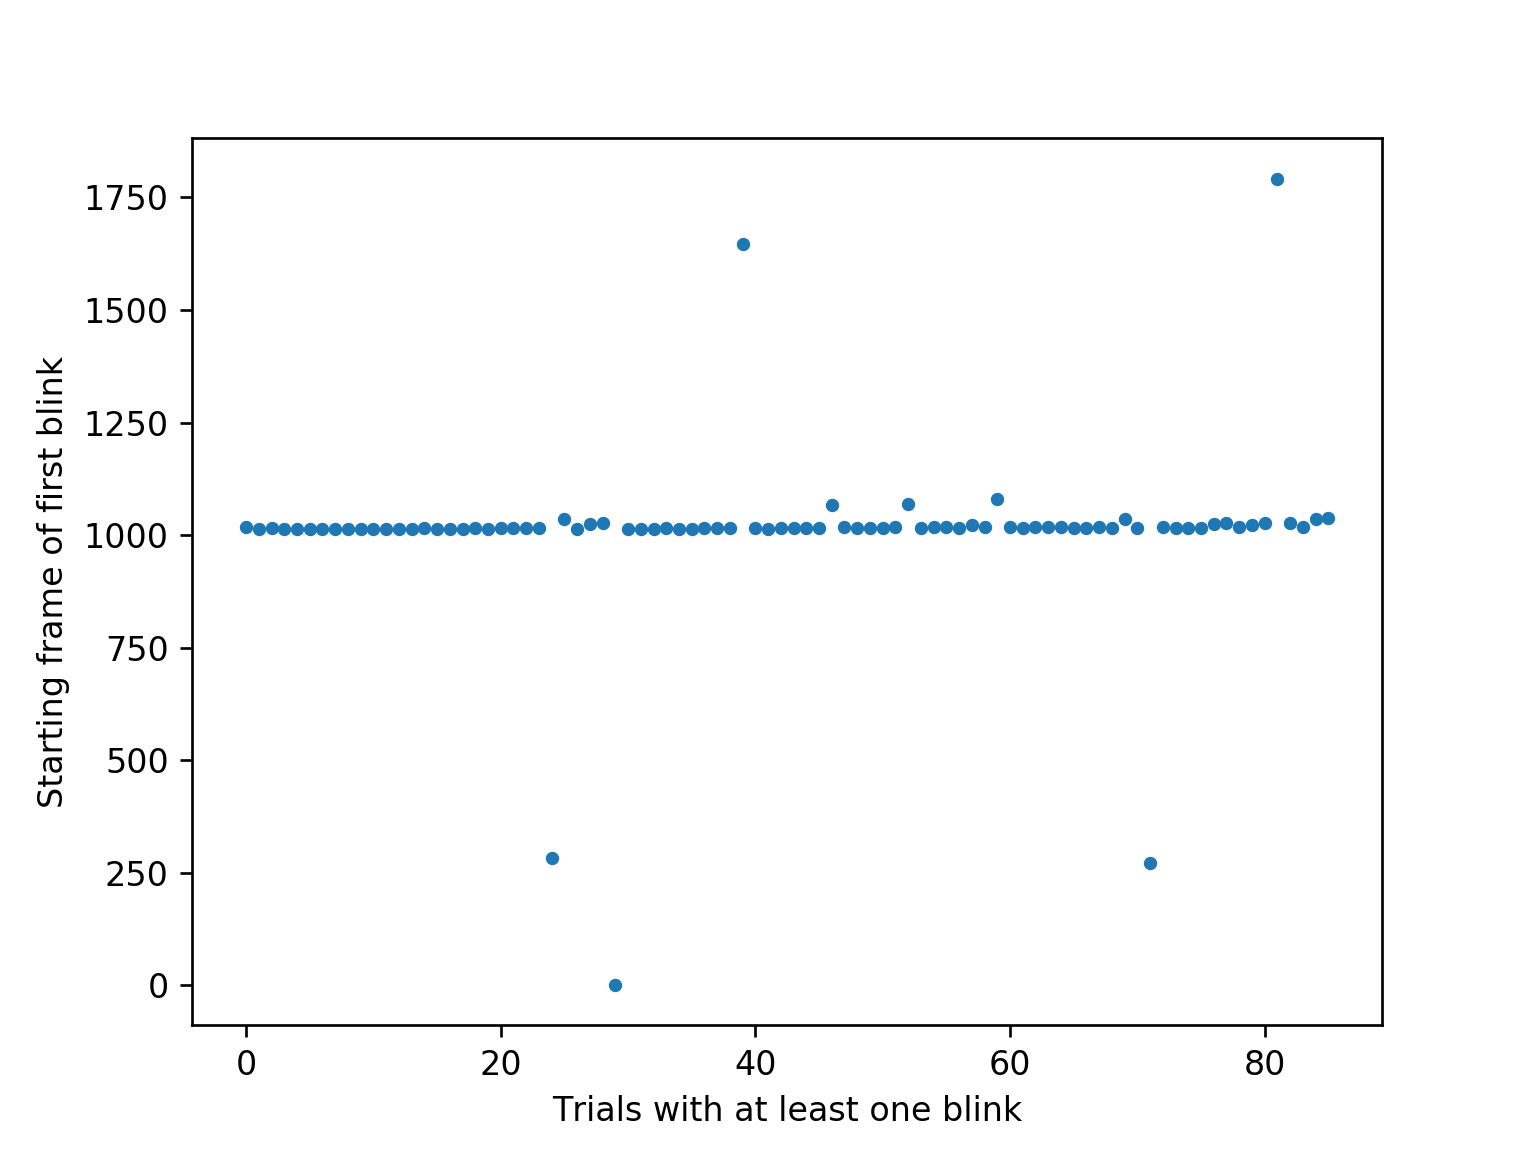

In [57]:
##############################################
# First blink times histogram
##############################################
firstBlinkTrials = [l[0] for l in framesBlinkTrialsStartTimes if len(l) != 0]

fig = plt.figure()
plt.plot(firstBlinkTrials, '.')
plt.xlabel("Trials with at least one blink")
plt.ylabel("Starting frame of first blink")
plt.show()

In [79]:
for i in range(len(framesBlinkTrialsLengths)):
    if len(framesBlinkTrialsLengths[i]) > 0:
        if min(framesBlinkTrialsLengths[i]) == 1:
            print(i)

83
113
150
153
160
175
278
390
